## Model Exploration (ML50-2023)

### __Importing libraries__

In [670]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import randint


# Data imports
test = pd.read_csv('Data/test_cleaned.csv', index_col=0)
train = pd.read_csv('Data/train_cleaned.csv', index_col=0)

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample

# Model imports
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Metrics imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### __Small processing__

In [653]:
train = train.reset_index(drop=True).drop(columns=['c_patient'])
b_target = train['b_target']
c_target = train['c_target']
train = train.drop(columns=['b_target', 'c_target', 'n_times_readmitted'])
test = test.drop(columns=['c_patient', 'n_times_readmitted'])

In [654]:
cols_payer = [col for col in train.columns if col.startswith('b_payer_')]
cols_drop = ['b_admission_Elective', 'b_admission_Urgent',
                                               'b_race_Asian', 'b_race_Hispanic', 'b_race_Other',
                                               'b_source_Referral', 'b_source_Transfer', 'b_source_Unknown'] + cols_payer
train_light = train.drop(columns=cols_drop)

cols_payer_group = [col for col in train.columns if col.startswith('b_payer_group_')]
train_heavy = train.drop(columns=cols_payer_group)

### __Model Testing__

### __Feature Selection__

#### __Functions__

In [655]:
def get_train_val(X_, y_, test_size=0.3, scaler=MinMaxScaler(), sampler='simple', minority_factor=1, verbose=False, return_scaler=False):    
    X = X_.copy()
    y = y_.copy()
    numeric_cols = [col for col in X.columns if col.startswith('n_')]
    if scaler:
        X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
        
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    if sampler == 'simple': 
        print(f'Simple sampling with minority factor {minority_factor}') if verbose else None
        X_res = pd.concat([X_train, y_train], axis=1)
        minority_class = X_res[X_res[y.name] == 1]
        majority_class = X_res[X_res[y.name] == 0]
        # Using the resample function to upsample the minority class
        minority_upsampled = resample(minority_class, replace=True, n_samples=int(len(majority_class)*minority_factor), random_state=42)

        upsampled = pd.concat([majority_class, minority_upsampled])
        X_train = upsampled.drop(columns=y.name)
        y_train = upsampled[y.name]
    # Using SMOTE to upsample the minority class, or other IMBLEARN samplers
    elif sampler:
        print('Using {} sampler'.format(sampler)) if verbose else None
        X_train, y_train = sampler.fit_resample(X_train, y_train)

    if return_scaler:
        return X_train, X_val, y_train, y_val, scaler
    else:
        return X_train, X_val, y_train, y_val 

In [675]:
def test_model(model, X_, y_, just_score=False, scaler=MinMaxScaler(), test_size=0.3, sampler='simple', minority_factor=1, verbose=False, return_scaler=False, return_X=False): 
    X = X_.copy()
    y = y_.copy()
    
    if return_scaler:
        X_train, X_test, y_train, y_test, scaler = get_train_val(X_=X, y_=y, test_size=test_size, scaler=scaler, sampler=sampler, minority_factor=minority_factor, verbose=verbose, return_scaler=return_scaler)
    else:
        X_train, X_test, y_train, y_test = get_train_val(X_=X, y_=y, test_size=test_size, scaler=scaler, sampler=sampler, minority_factor=minority_factor, verbose=verbose, return_scaler=return_scaler)
    
    fit = model.fit(X_train, y_train)
    y_pred = fit.predict(X_test)
    if just_score:
        return fit, f1_score(y_test, y_pred)
    
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred))
    print('Recall: ', recall_score(y_test, y_pred))
    print('F1: ', f1_score(y_test, y_pred))
    print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
    print('Classification report: \n', classification_report(y_test, y_pred))
    if return_scaler and return_X:
        return fit, scaler, X_test, y_test
    elif return_scaler:
        return fit, scaler
    elif return_X:
        return fit, X_test, y_test
    else :
        return fit

In [657]:
def perform_random_search(X, y, model, params_dict, sampler=RandomOverSampler(), scaler=MinMaxScaler(), target='b_target'):
   # Create a pipeline
   pipeline = ImbPipeline([
       ('sampler', sampler),
       ('scaler', scaler),
       ('model', model)
   ])

   # Perform randomized search
   random_search = RandomizedSearchCV(pipeline, params_dict, cv=5, n_jobs=1, random_state=42, verbose=1, scoring='f1')
   random_search.fit(X, y)

   # Print the best parameters
   print("Best parameters: ", random_search.best_params_)

   # Return the best estimator
   return random_search.best_estimator_

In [658]:
def test_model_cv(X_, y_, model, params, scaler, sampler='simple', minority_factor=1, target='b_target', cv=5, scoring='f1', verbose=True, score_greedy=None):
    X = X_.copy()
    y = y_.copy()
    # Lets program the cv manually so that we can track the progress
    kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    print(params) if verbose else None
    model = model(**params, random_state=42, n_jobs=-1)
    scores_test, scores_train = [], []
    for i, (train_index, test_index) in enumerate(kf.split(X, y)):
        print(f'Starting fold {i+1}/{cv}...') if verbose else None
        X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train, y_test = y.iloc[train_index][target].copy(), y.iloc[test_index][target].copy()
        X_train = X_train.drop(columns=['b_target', 'c_target'])
        X_test = X_test.drop(columns=['b_target', 'c_target'])

        # Scale the data
        numeric_cols = [col for col in X_train.columns if col.startswith('n_')]
        X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
        X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

        # Resample the data
        if sampler == 'simple':
            X_res = pd.concat([X_train, y_train], axis=1)
            minority_class = X_res[X_res[target] == 1]
            majority_class = X_res[X_res[target] == 0]
            # Using the resample function to upsample the minority class
            minority_upsampled = resample(minority_class, replace=True, n_samples=int(len(majority_class)*minority_factor), random_state=42)
            upsampled = pd.concat([majority_class, minority_upsampled])
            X_train = upsampled.drop(columns=target)
            y_train = upsampled[target]
        elif sampler:
            X_train, y_train = sampler.fit_resample(X_train, y_train)

        # Fit the model
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_test)

        # Score
        score_test = f1_score(y_test, y_pred)
        score_train = f1_score(y_train, model.predict(X_train))
        scores_test.append(score_test)
        scores_train.append(score_train)

        if score_greedy and score_test < score_greedy and i < 2:
            print(f'Finished fold {i+1}/{cv}. Score train: {score_train}, score test: {score_test}. Stopping early...') if verbose else None
            return score_test

        print(f'Finished fold {i+1}/{cv}. Score train: {score_train}, score test: {score_test}') if verbose else None
    print(f'Average score: {np.mean(scores_test)} for params: {params}') if verbose else None
    return np.mean(scores_test)

In [663]:
def random_search_manual(X_, y_, model, params, scaler, sampler='simple', iter=10, target='b_target', cv=5, scoring='f1', verbose=True, score_greedy=None):
    X = X_.copy()
    y = y_.copy()
    # We will use the test_model_cv function to perform the random search
    best_score = 0
    best_params = None

    print(f'Doing {iter} iterations with {cv} folds, totally {iter*cv} fits...') if verbose else None
    for i in range(iter):
        print(f'Iteration {i+1}/{iter}...') if verbose else None
        params_ = {k : np.random.choice(v) for k, v in params.items()}
        score = test_model_cv(X_=X, y_=y, model=model, params=params_, scaler=scaler, sampler=sampler, minority_factor=1, target=target, cv=cv, scoring=scoring, verbose=verbose, score_greedy=score_greedy)
        if score > best_score:
            best_score = score
            best_params = params_
    
    print(f'Best score: {best_score} for params: {best_params}') if verbose else None
    return best_params

In [ ]:
def submit (test, fit, scaler): 
    numerical_features = [col for col in train.columns if col.startswith('n_')]
    X_test = test.drop(columns=cols_drop)
    X_test[numerical_features] = scaler.transform(X_test[numerical_features])
    y_pred = fit.predict(X_test)
    predictions = pd.DataFrame(y_pred, index=test.index, columns=['readmitted_binary'])
    predictions['readmitted_binary'].apply(lambda x: 'Yes' if x == 1 else 'No').to_csv('predictions.csv', header=True)

#### __Logistic Regression__

__Relevant Information:__

##### Simple Logistic Regression

In [676]:
model = LogisticRegression(max_iter=1000)

fit, X_val, y_val = test_model(model, train_light, b_target, test_size=0.3, return_X=True)

Accuracy:  0.6937295273748245
Precision:  0.20063327576280945
Recall:  0.5844863731656185
F1:  0.2987249544626594
Confusion matrix: 
 [[13431  5554]
 [  991  1394]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.93      0.71      0.80     18985
         1.0       0.20      0.58      0.30      2385

    accuracy                           0.69     21370
   macro avg       0.57      0.65      0.55     21370
weighted avg       0.85      0.69      0.75     21370



#### __Random Forest Classifier__

Best score: 0.2930728334843782 for params: {'n_estimators': 343, 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 16, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced'}


In [662]:
params_dict = {
  'n_estimators': [val for val in range(100, 350)],
  #'max_depth': [val for val in range(2, 25)],
  'min_samples_split': [val for val in range(2,60)],
  'min_samples_leaf': [val for val in range(2,60)],
  'max_features': ['sqrt', 'log2', None],
  'bootstrap': [True, False],
  'criterion': ['gini', 'entropy'],
  'class_weight': [None] # ['balanced_subsample', 'balanced']
}

best_estimator = random_search_manual(train_light,b_target, model=RandomForestClassifier, params=params_dict, 
                                      scaler=MinMaxScaler(), iter=50, sampler='simple', score_greedy=0.29, cv=5)

Doing 50 iterations with 5 folds, totally 250 fits...
Iteration 1/50...


TypeError: test_model_cv() got an unexpected keyword argument 'X'

In [672]:
# Get the score of the best estimator
model = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini', max_features='sqrt', min_samples_leaf=20,
                       min_samples_split=2, n_estimators=150, n_jobs=-1, max_depth=None, random_state=42)

fit, scaler = test_model(model, train_light, b_target, test_size=0.3, sampler='simple', return_scaler=True, scaler=MinMaxScaler())

Accuracy:  0.7920917173607861
Precision:  0.2506059137178866
Recall:  0.43354297693920335
F1:  0.3176163415757948
Confusion matrix: 
 [[15893  3092]
 [ 1351  1034]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.92      0.84      0.88     18985
         1.0       0.25      0.43      0.32      2385

    accuracy                           0.79     21370
   macro avg       0.59      0.64      0.60     21370
weighted avg       0.85      0.79      0.81     21370



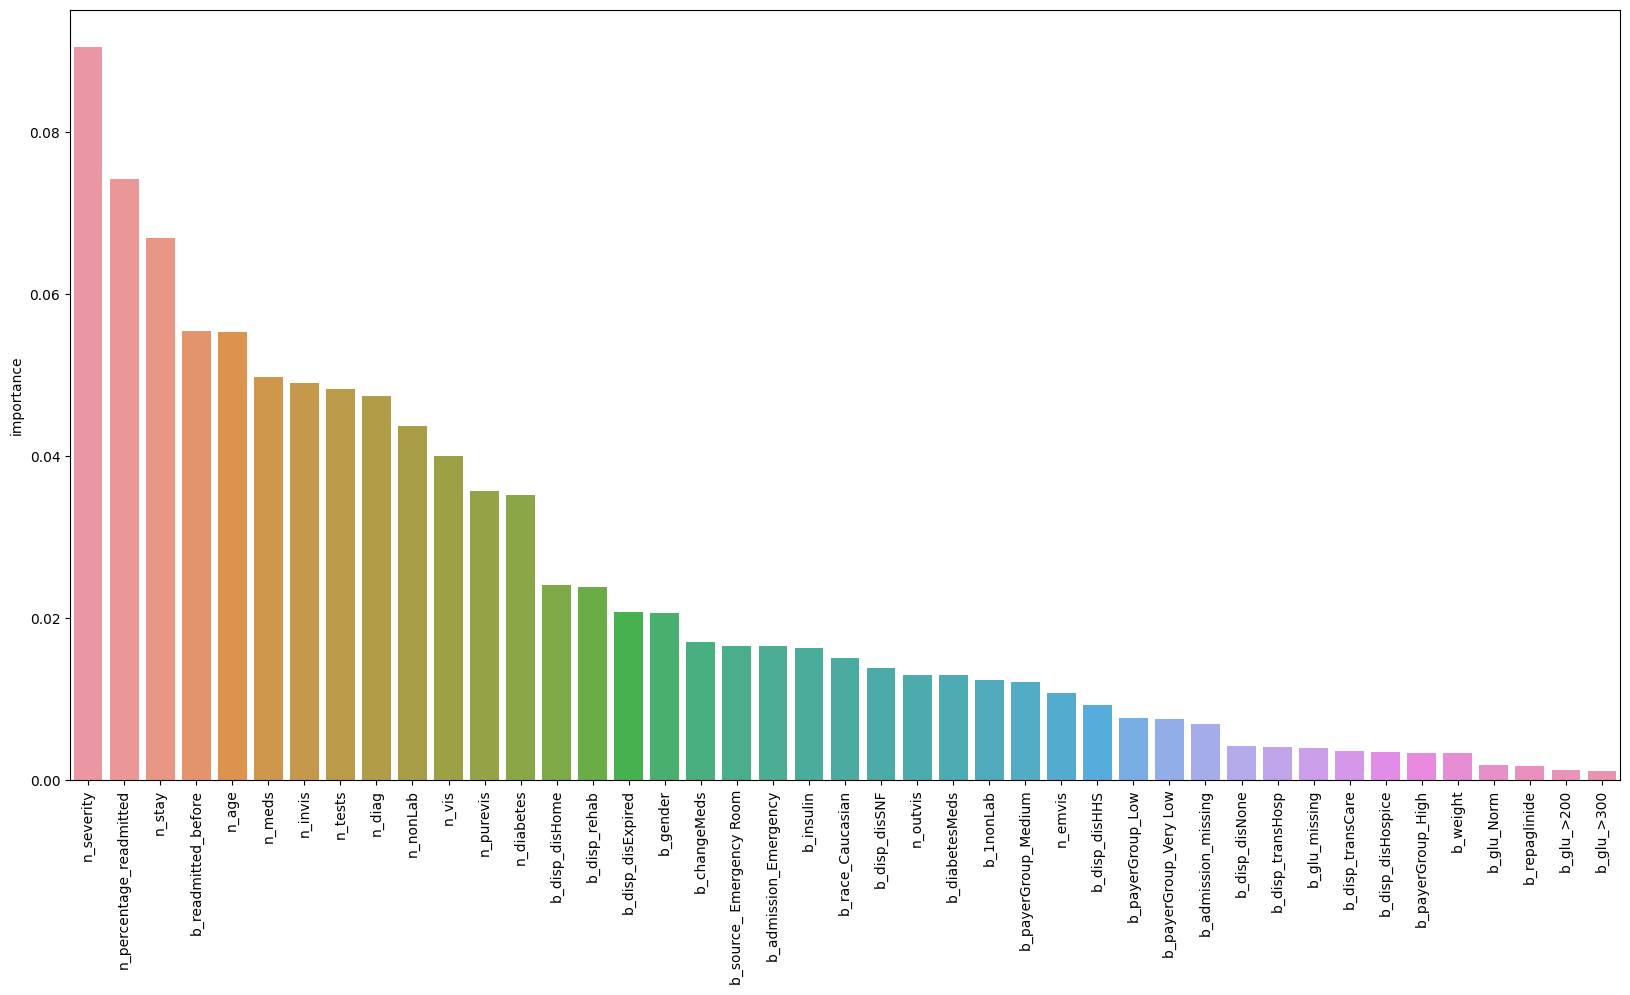

In [673]:
# Get the feature importances
feature_importances = pd.DataFrame(fit.feature_importances_,
                                   index = train_light.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(20, 10))
sns.barplot(x=feature_importances.index, y=feature_importances['importance'])
plt.xticks(rotation=90)
plt.show()